# Predicting Pet Insurance Claims - Pre-processing
## 1 Introduction
### 1.1 Background
Whenever a pet insurance policy holder incurs veterinary expenses related to their enrolled pet, they can submit claims for reimbursement, and the insurance company reimburses eligible expenses. To price insurance products correctly, the insurance company needs to have a good idea of the amount their policy holders are likely to claim in the future.

### 1.2 Project Goal
The goal of this project is to create a machine learning model to predict how much (in dollars) a given policy holder will claim for during the second year of their policy.

### 1.3 Notebook Goals
* Split data into Train and Test sets
* Complete any remaining feature engineering
* Pre-process the data to prepare for modeling

## 2 Setup
### 2.1 Imports

In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import __version__ as sklearn_version

import datetime
import os
import pickle
from library.sb_utils import save_file

### 2.2 Data Load and Preview
At the end of exploratory data analysis, we had an updated data file for our pets data containing all pet records. As a quick review, here's a summary:
* Shape - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* Basic Info - For each pet, we have some basic info including species, breed, and age at time of enrollment.
* YoungAge - Designation for pets who enrolled at a very young age (< 7 weeks)
* Policy Info - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* Claims Data - We also have claims data for each pet covering the first two policy years including:
* Number of claims per year and total (years 1 and 2 combined)
* Average claim amount per year and total (years 1 and 2 combined)
* Amount of claims per year and total (years 1 and 2 combined)

Let's load in the data and preview.

In [2]:
pets = pd.read_csv('../data/pets.csv', index_col=0)
pets.head(8).T

,0,1,2,3,4,5,6,7
PetId,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat,Dog
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair,Boxer
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4,75.14
Deductible,200,500,500,500,700,700,250,700
AgeYr1,3,0,0,0,0,2,0,5
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0,2873.47
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38,2497.03
AvgClaimsYr1,0.0,0.0,213.543333,0.0,801.361111,296.185556,0.0,410.495714


### 2.3 Initial Plan for Pre-processing and Feature Engineering
Our primary goal for pre-processing will be to prepare our data for modeling. At a our minimum, this will include scaling and/or normalizing our features against one another, generating any required dummy values for categorical columns and splitting our data into our train and test sets.

**Train / Test Prep**
* Drop all 'Yr2' and 'Total' columns except AmtClaimsYr2 (our target) as this is data we would not have available for making predictions
* Split our data into training and test sets

**Feature Engineering** 
* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed - Employ a method to reduce the number of unique values
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)
* AmtClaimsYr1 and AvgClaimsYr1 - consider rolling these up into one feature or rolling these up by breed
* NumClaimsYr1 - Consider dropping this column or rolling up by breed; Could also be converted to binary (claims and no-claims)

**Pre-processing**
* Species - Convert to binary
* Breed - Create dummy variables for the remaining breeds
* All columns - Scale or normalize any columns not already converted to binary or dummy variables


## 3 Split the Data
As a first step, we'll take care of the train/test split to prevent any data leakage. Before we split the data, we need to drop some of the features that won't be part of our model. 

In addition, we observed in data wrangling and EDA, that there are a wide variety of breeds in our data. If we want to maintain a balanced distribution of breeds after our split, we'll need to use *stratify* to achieve this. Stratify won't work with our current data since we have some breeds with only 1 pet and stratify requires a minimum of 2 in each category.

To work around this, we can take a few steps to reduce the number of unique values for 'Breed'. In doing so, we can ensure a minimum number of pets in each category. 

### 3.1 Drop Unnecessary Features 
We have a number of features in our current dataset that would be unfair to use in our predictive model. The purpose of our model will be to predict claims in year 2. That being the case, we need to remove any features that include data for year 2.

In [3]:
# Drop features that won't be part of the model
drop_cols = ['PetId', 'AvgClaimsYr2', 'NumClaimsYr2', 'AmtClaimsTotal', 'AvgClaimsTotal',
             'NumClaimsTotal', 'YrsWithClaims']
pets.drop(columns=drop_cols, inplace=True)

### 3.2 Reduce the Number of Unique Breeds
To reduce the number of unique breeds in the data, we'll follow the steps below:

1. Set threshold and save a list of breeds with counts greater or equal to the threshold
2. Write a function to update the breed for a row based on whether or not it exists in the list from step 1
3. Create a copy of our original df and apply the function
4. Print out the before and after numbers for our count of unique breeds

As part of step 2 above, we'll update the breed name for breeds with a low pet count to group them together in an *Other* category. To ensure we don't lose any species-specific information, we'll create two versions of *Other*, 'Other Cat' and 'Other Dog'. 

In [4]:
breeds = pd.read_csv('../data/breeds.csv', index_col=0)
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,Abyssinian,Affenpinscher,Afghan Hound,Aidi,Airedale Terrier,Akbash Dog,Akita,Alaskan Klee Kai,Alaskan Malamute,American Bandogge Mastiff
Species,Cat,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
PetCount,24,3,10,2,41,1,49,30,64,1
AvgTotalClaims,1462.780417,1746.19,645.543,0.0,1338.705366,11383.6,1217.91102,1510.666333,3096.346719,2295.07
AvgNumClaims,4.25,1.333333,2.5,0.0,2.097561,23.0,3.591837,3.166667,3.765625,8.0
WeightedTotalClaims,35106.73,5238.57,6455.43,0.0,54886.92,11383.6,59677.64,45319.99,198166.19,2295.07
WeightedNumClaims,102.0,4.0,25.0,0.0,86.0,23.0,176.0,95.0,241.0,8.0


In [5]:
# Set threshold
threshold = 100

# Preserve list of Breeds with count greater equal to the threshold
breeds_list = breeds[breeds.PetCount >= threshold].Breed.tolist()

# Create function to update breed column based on threshold
def update_breed(row):
    if (row["Breed"] in breeds_list):
        return row["Breed"]
    else:
        if (row["Species"] == 'Cat'):
            return 'Other Cat'
        else:
            return 'Other Dog'

# Print number of unique breeds before update
print("Number of unique breeds before: " + str(pets.Breed.nunique()))

# Apply function to update Breed
pets["Breed"] = pets.apply(update_breed, axis=1)
print("Number of unique breeds after: " + str(pets.Breed.nunique()))

Number of unique breeds before: 373
Number of unique breeds after: 79


### 3.3 Split Data into Train and Test

In [6]:
# Split out target and features
y = pets["AmtClaimsYr2"].values
X = pets.drop(columns="AmtClaimsYr2")

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=pets['Breed'])

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 9)
(10000, 9)
(40000,)
(10000,)


## 4 Feature Engineering
Now that we've split the data into train and test sets, we can proceed with feature engineering without worrying about data leakage. As a next step, let's replace our **breeds** dataframe (which was based on the entire dataset) with an updated version based on our training dataset. Then we can pull in some of the summary statistics as new features.

* Premium and Deductible - Roll these features up to the breed level to smooth out some of the variability between pets that are in essence, identical
* Breed statistics - Add features to incorporate breed-related statistics into pets data
* PetAge - Consider adding a new features factoring in age (e.g., average claim amount in year 1, average total claims in year 1 - by age grouping)

### 4.1 Breed Statistics
After we create our new dataframe grouped by breed, we'll write a function to pull the summary statistics into our training data. 

In [8]:
# Group pets by breed and aggregate data
breeds = X_train.groupby(by=['Breed', 'Species']).agg({'Breed': ['count'],
                                                       'Premium': ['mean'],
                                                       'Deductible': ['mean'],
                                                       'AmtClaimsYr1': ['mean'],
                                                       'NumClaimsYr1': ['mean'],
                                                       'AvgClaimsYr1': ['mean']}).reset_index()
breeds.columns = ['Breed', 'Species', 'PetCount', 'BreedAvgPremium', 'BreedAvgDeductible',
                  'BreedAvgTotalClaims', 'BreedAvgNumClaims', 'BreedAvgClaimAmt']
breeds.head(10).T

,0,1,2,3,4,5,6,7,8,9
Breed,American Pitbull Terrier,American Shorthair,American Staffordshire Terrier,Aussiedoodle,Australian Labradoodle,Australian Shepherd,Beagle,Bengal,Bernedoodle,Bernese Mountain Dog
Species,Dog,Cat,Dog,Dog,Dog,Dog,Dog,Cat,Dog,Dog
PetCount,270,322,85,83,502,380,199,117,232,255
BreedAvgPremium,90.332481,45.054161,87.896353,57.588675,55.115598,59.496658,78.555025,40.441709,72.315216,106.844392
BreedAvgDeductible,516.333333,450.776398,538.235294,472.891566,482.778884,502.618421,546.055276,405.726496,460.625,597.039216
BreedAvgTotalClaims,1379.329741,418.527795,1234.249294,442.366024,604.670657,525.991211,1013.245427,816.974188,864.134914,1469.510667
BreedAvgNumClaims,2.151852,0.720497,1.917647,1.180723,1.898406,1.123684,1.929648,1.145299,2.478448,2.52549
BreedAvgClaimAmt,415.730998,167.279709,306.883843,149.906525,161.047367,193.854285,273.893588,194.248052,209.968613,305.445489


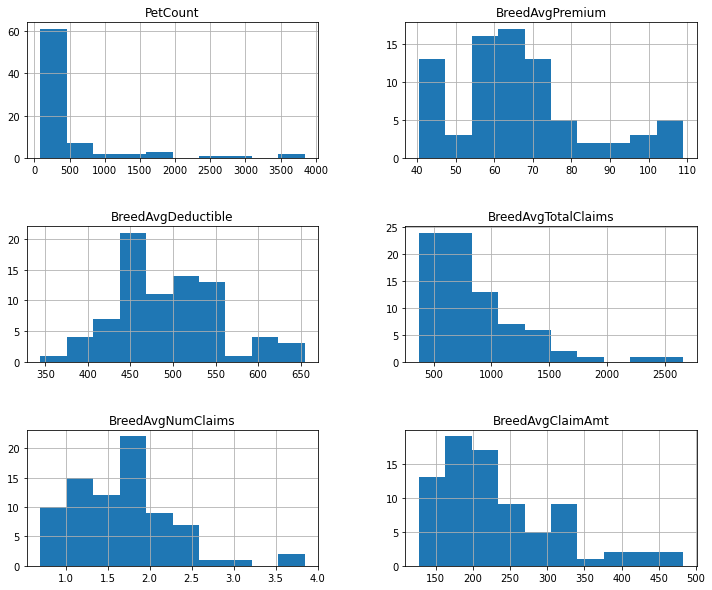

In [9]:
# Preview the distributions of each of our numeric features
breeds.hist(figsize=(12,10))
plt.subplots_adjust(hspace=0.5)
plt.show()

In the distributions above, we see a lot of variability across our different breeds for each of our numeric columns. This provides further evidence that breed matters when it comes to differentiating our pets. As a next step, we'll create a function to add these stats into our train data.

In [10]:
# Create function to pull breed statistics into pets dataframe
def add_breed_stats(df):
    features = ['Breed', 'BreedAvgPremium', 'BreedAvgDeductible', 'BreedAvgTotalClaims',
                'BreedAvgNumClaims', 'BreedAvgClaimAmt']
    breed_stats = breeds.copy()[features]
    df = pd.merge(df, breed_stats, how='left', on='Breed')
    return df

In [11]:
# Apply function to training and test data & preview result
X_train = add_breed_stats(X_train)
X_test = add_breed_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
Breed,Cockapoo,Maltese,Mixed Breed Small,Cockapoo,Other Dog,Mixed Breed Small,Mixed Breed Medium,Bernedoodle
Premium,46.52,106.65,69.93,92.12,75.15,45.17,36.2,78.28
Deductible,250,200,240,500,1000,1000,700,250
AgeYr1,0,0,3,5,0,6,0,1
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,2718.64,989.1,0.0,0.0,358.0,1542.38,0.0
AvgClaimsYr1,0.0,906.213333,989.1,0.0,0.0,358.0,308.476,0.0
NumClaimsYr1,0,3,1,0,0,1,5,0
BreedAvgPremium,55.858394,63.786192,60.846209,55.858394,72.940325,60.846209,61.84971,72.315216


In [12]:
# Check for null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              40000 non-null  object 
 1   Breed                40000 non-null  object 
 2   Premium              40000 non-null  float64
 3   Deductible           40000 non-null  int64  
 4   AgeYr1               40000 non-null  int64  
 5   YoungAge             40000 non-null  int64  
 6   AmtClaimsYr1         40000 non-null  float64
 7   AvgClaimsYr1         40000 non-null  float64
 8   NumClaimsYr1         40000 non-null  int64  
 9   BreedAvgPremium      40000 non-null  float64
 10  BreedAvgDeductible   40000 non-null  float64
 11  BreedAvgTotalClaims  40000 non-null  float64
 12  BreedAvgNumClaims    40000 non-null  float64
 13  BreedAvgClaimAmt     40000 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 4.6+ MB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Species              10000 non-null  object 
 1   Breed                10000 non-null  object 
 2   Premium              10000 non-null  float64
 3   Deductible           10000 non-null  int64  
 4   AgeYr1               10000 non-null  int64  
 5   YoungAge             10000 non-null  int64  
 6   AmtClaimsYr1         10000 non-null  float64
 7   AvgClaimsYr1         10000 non-null  float64
 8   NumClaimsYr1         10000 non-null  int64  
 9   BreedAvgPremium      10000 non-null  float64
 10  BreedAvgDeductible   10000 non-null  float64
 11  BreedAvgTotalClaims  10000 non-null  float64
 12  BreedAvgNumClaims    10000 non-null  float64
 13  BreedAvgClaimAmt     10000 non-null  float64
dtypes: float64(8), int64(4), object(2)
memory usage: 1.1+ MB


So after pulling in our breed stats, we can see that we don't have any missing values in our data. Next, let's move on to look at Premium and Deductible.

### 4.2 Premium and Deductible
Now that we have the Premium and Deductible rolled up to a breed-level statistic, we should be able to safely drop the pet-level columns. The rationale for this is that customers can select either a premium or a deductible and once one is selected, the other is set automatically. 

This leads to a couple of conclusions:
* At a pet-level, we expect to see a wide range of premiums and deductibles for a single breed (due to customer choice)
* When we average these values out at a breed level, we should see some patterns emerging that might be indicative of the *assumed risk level* for each breed.

Let's take a look.

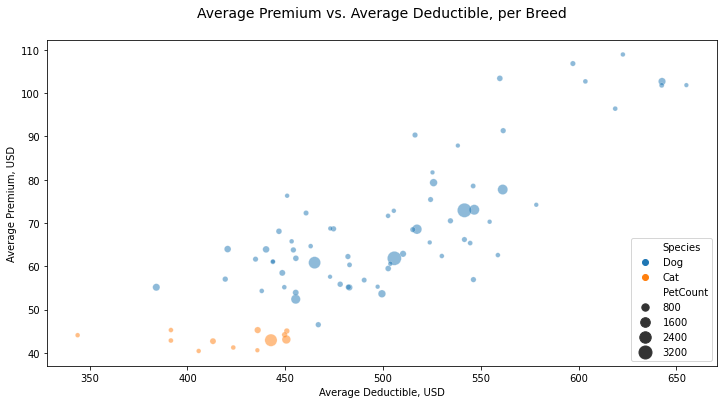

In [14]:
# Create a scatterplot showing spread vs. average total claims
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.scatterplot(y="BreedAvgPremium", x="BreedAvgDeductible", data=breeds, hue="Species", 
                size="PetCount", sizes=(20, 200), alpha=0.5)\
                .set(title="", ylabel="Average Premium, USD",
                     xlabel="Average Deductible, USD")

# Add title and display plot
plt.title("Average Premium vs. Average Deductible, per Breed", y=1.05, fontsize=14)
# plt.suptitle("(TBD)", y=0.95, x=0.513, fontsize=11)
plt.legend(loc='lower right')
plt.show()

The plot above shows a couple of interesting insights.

1. Premiums and deductibles are consistently lower for cats
2. As the average deductible amount goes up for cat breeds, the average premium amount stays roughly the same
3. As the average deductible amount goes up for dog breeds, the average premium amount goes up at a fairly steady linear rate

**So the overall takeaways:**
* Cats seem to be considered lower risk than dogs
* For dog breeds, the premium and deductible amounts vary and could indicate that some breeds are considered riskier to insure than others

Let's drop the pet-level premium and deductible features before moving on.

In [15]:
# Drop Premium and Dedictible columns
X_train = X_train.drop(columns=['Premium', 'Deductible'])
X_test = X_test.drop(columns=['Premium', 'Deductible'])

### 4.3 Pet Age
Summarizing our data by breed helped to highlight an interesting trend in our premium and deductible features. 

**Are there features we could engineer based on the age of our pets at time of enrollment that might help our predictive model?** 

Similar to breed, we would expect a wide range of vairiability in our claims data on a per-pet basis at each age level. However, averaging the claims data per age could help to offset some of that variability we see for individual pets. 

We'll start by grouping our data based on pet age and species.

In [16]:
# Group pets by age at enrollment and aggregate data
pets_by_age = X_train.groupby(by=["AgeYr1", "Species"]).agg({'AgeYr1': ['count'],
                                                             'AmtClaimsYr1': ['mean'],
                                                             'NumClaimsYr1': ['mean'],
                                                             'AvgClaimsYr1': ['mean']}).reset_index()
pets_by_age.columns = ['AgeYr1', 'Species', 'PetCount', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims',
                       'AgeYr1AvgClaimAmt']
pets_by_age.head(10).T

,0,1,2,3,4,5,6,7,8,9
AgeYr1,0,0,1,1,2,2,3,3,4,4
Species,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog,Cat,Dog
PetCount,3167,22176,737,3028,580,2119,413,1439,305,1139
AgeYr1AvgTotalClaims,440.450107,922.655856,402.266269,698.393814,296.296603,631.804799,245.376634,687.28549,552.453541,742.114293
AgeYr1AvgNumClaims,0.97095,1.993371,0.736771,1.352708,0.543103,1.243039,0.513317,1.216122,0.881967,1.24583
AgeYr1AvgClaimAmt,139.996044,239.463352,157.43411,213.125274,119.931117,199.63438,109.135813,225.04824,201.259725,225.592818


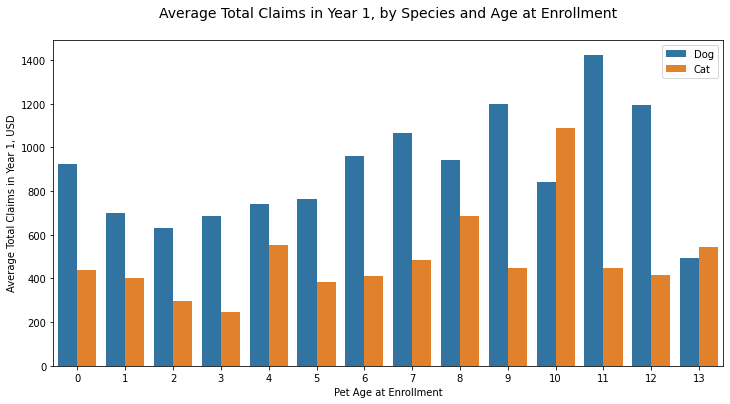

In [17]:
# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.barplot(x="AgeYr1", y="AgeYr1AvgTotalClaims", hue="Species", data=pets_by_age, hue_order=['Dog', 'Cat'] 
           ).set(xlabel="Pet Age at Enrollment", ylabel="Average Total Claims in Year 1, USD")

# Plot the legend and display
plt.title("Average Total Claims in Year 1, by Species and Age at Enrollment", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

As noted in EDA, dogs pretty consistently have higher average total claims than cats at just about every age level with the exception of a couple of ages at the high end of our range. 

There is a bit more variability in the trends for each species across the age range. We see that as age increases, the average claims amount tends to rise, but it's not a clear linear relationship. In any case, incorporating these averages should help our predictive model by adding some population-level features into the mix.  

In [18]:
# Create function to pull age statistics into pets dataframe
def add_age_stats(df):
    features = ['AgeYr1', 'Species', 'AgeYr1AvgTotalClaims', 'AgeYr1AvgNumClaims', 'AgeYr1AvgClaimAmt']
    age_stats = pets_by_age.copy()[features]
    df = pd.merge(df, age_stats, how='left', on=(['AgeYr1', 'Species']))
    return df

In [19]:
# Apply function to training and test data & preview result
X_train = add_age_stats(X_train)
X_test = add_age_stats(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,Dog,Dog,Dog,Dog,Dog,Dog,Dog,Dog
Breed,Cockapoo,Maltese,Mixed Breed Small,Cockapoo,Other Dog,Mixed Breed Small,Mixed Breed Medium,Bernedoodle
AgeYr1,0,0,3,5,0,6,0,1
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,2718.64,989.1,0.0,0.0,358.0,1542.38,0.0
AvgClaimsYr1,0.0,906.213333,989.1,0.0,0.0,358.0,308.476,0.0
NumClaimsYr1,0,3,1,0,0,1,5,0
BreedAvgPremium,55.858394,63.786192,60.846209,55.858394,72.940325,60.846209,61.84971,72.315216
BreedAvgDeductible,478.075758,454.139073,464.985075,478.075758,541.6077,464.985075,505.767061,460.625
BreedAvgTotalClaims,512.823455,875.733411,691.087116,512.823455,909.284781,691.087116,790.604769,864.134914


## 5. Data Pre-processing
Now that we've engineered a couple of new features, let's take a look at our data and complete any additional pre-processing so we are ready to move on to model creation.

As part of pre-processing, we need to decide what to to with our remaining categorical features - Breed and Species.

Before we start, let's review the dtypes in our dataset.

In [20]:
X_train.dtypes

Species                  object
Breed                    object
AgeYr1                    int64
YoungAge                  int64
AmtClaimsYr1            float64
AvgClaimsYr1            float64
NumClaimsYr1              int64
BreedAvgPremium         float64
BreedAvgDeductible      float64
BreedAvgTotalClaims     float64
BreedAvgNumClaims       float64
BreedAvgClaimAmt        float64
AgeYr1AvgTotalClaims    float64
AgeYr1AvgNumClaims      float64
AgeYr1AvgClaimAmt       float64
dtype: object

Perfect... only two object columns to deal with - Breed and Species. Let's start with Species.

### 5.1 Convert Species to Binary 
For species, we have two possible values - Cat or Dog. To convert this to binary, we'll need to assign each of the possible values as a 1 or 0.

In [21]:
# Create function to convert species to binary
def species_to_binary(df):
    df["Species"] = np.where(df["Species"].str.contains("Dog"), 1, 0)
    return df

In [22]:
# Apply function to training and test data & preview result
X_train = species_to_binary(X_train)
X_test = species_to_binary(X_test)

X_train.head(8).T

,0,1,2,3,4,5,6,7
Species,1,1,1,1,1,1,1,1
Breed,Cockapoo,Maltese,Mixed Breed Small,Cockapoo,Other Dog,Mixed Breed Small,Mixed Breed Medium,Bernedoodle
AgeYr1,0,0,3,5,0,6,0,1
YoungAge,0,0,0,0,0,0,0,0
AmtClaimsYr1,0.0,2718.64,989.1,0.0,0.0,358.0,1542.38,0.0
AvgClaimsYr1,0.0,906.213333,989.1,0.0,0.0,358.0,308.476,0.0
NumClaimsYr1,0,3,1,0,0,1,5,0
BreedAvgPremium,55.858394,63.786192,60.846209,55.858394,72.940325,60.846209,61.84971,72.315216
BreedAvgDeductible,478.075758,454.139073,464.985075,478.075758,541.6077,464.985075,505.767061,460.625
BreedAvgTotalClaims,512.823455,875.733411,691.087116,512.823455,909.284781,691.087116,790.604769,864.134914


In [23]:
# Confirm Species value counts
X_train.Species.value_counts()

1    33580
0     6420
Name: Species, dtype: int64

### 5.2 Convert Breed to Numeric
For 'Breed' we have a different situation given that we have 79 possible unique values in the column. In order to convert this to numeric, we'll need to use one-hot encoding.

In [24]:
# Create function to encode Breed 
def breed_to_numeric(df):
    df = pd.get_dummies(df, columns=['Breed'], prefix="Breed")
    return df

In [25]:
# Preview shape before conversion
shape_before = X_train.shape

# Apply function to df
X_train = breed_to_numeric(X_train)
X_test = breed_to_numeric(X_test)

# Get shape after conversion
shape_after = X_train.shape

# Print results
print("Shape before: " + str(shape_before))
print("Shape after: " + str(shape_after))

Shape before: (40000, 15)
Shape after: (40000, 93)


In [26]:
# Confirm all features are numeric
X_train.dtypes.value_counts()

uint8      79
float64    10
int64       4
dtype: int64

## 6 Initial Modeling
Before we start working toward establishing our final model, let's start by reviewing the results that we get with a few different baseline models.

For this baseline evaluation, we'll create two *dummy* regressors, one using the mean for predictions and one using the median. Then we'll compare these to a basic linear regression model to see how they perform.

### 6.1 Model Baseline

In [27]:
# Create initial baseline models
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_train, y_train)

# Make predictions using baseline models
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
y_predict_dummy_median = lm_dummy_median.predict(X_test)

In [28]:
# Print comparison of the results 
print("Mean squared error (dummy mean): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_mean)))
print("Mean squared error (dummy median): {:.2f}".format(mean_squared_error(y_test, y_predict_dummy_median)))
print("Mean squared error (linear model): {:.2f} \n".format(mean_squared_error(y_test, y_predict)))

print("Mean absolute error (dummy mean): {:.2f}".format(mean_absolute_error(y_test, y_predict_dummy_mean)))
print("Mean absolute error (dummy median): {:.2f}".format(mean_absolute_error(y_test, y_predict_dummy_median)))
print("Mean absolute error (linear model): {:.2f} \n".format(mean_absolute_error(y_test, y_predict)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_predict)))

Mean squared error (dummy mean): 5428556.59
Mean squared error (dummy median): 5932757.77
Mean squared error (linear model): 4934688.74 

Mean absolute error (dummy mean): 1024.22
Mean absolute error (dummy median): 710.45
Mean absolute error (linear model): 935.38 

r2_score (dummy mean): -0.00
r2_score (dummy median): -0.09
r2_score (linear model): 0.09


Based on the results above, we see that all of our baseline models (dummy and linear) are performing poorly when it comes to making predictions against our test set. Predictions using the median value perform best in terms of the lowest MAE, but the basic linear regression model looks better in terms of MSE and R-Squared.

As a next step, let's try scaling the data to see if this makes a difference in model performance.

### 6.2 Scaling the Data

In [29]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [30]:
# Create baseline models using scaled data
lm = LinearRegression().fit(X_tr_scaled, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_tr_scaled, y_train)
lm_dummy_median = DummyRegressor(strategy = 'median').fit(X_tr_scaled, y_train)

# Make predictions using baseline models
y_pred_scaled = lm.predict(X_te_scaled)
y_pred_scaled_dummy_mean = lm_dummy_mean.predict(X_te_scaled)
y_pred_scaled_dummy_median = lm_dummy_median.predict(X_te_scaled)

In [31]:
# Print comparison of the results 
print("Mean squared error (dummy mean): {:.2f}".format(mean_squared_error(y_test, y_pred_scaled_dummy_mean)))
print("Mean squared error (dummy median): {:.2f}".format(mean_squared_error(y_test, y_pred_scaled_dummy_median)))
print("Mean squared error (linear model): {:.2f} \n".format(mean_squared_error(y_test, y_pred_scaled)))

print("Mean absolute error (dummy mean): {:.2f}".format(mean_absolute_error(y_test, y_pred_scaled_dummy_mean)))
print("Mean absolute error (dummy median): {:.2f}".format(mean_absolute_error(y_test, y_pred_scaled_dummy_median)))
print("Mean absolute error (linear model): {:.2f} \n".format(mean_absolute_error(y_test, y_pred_scaled)))

print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_pred_scaled_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_pred_scaled_dummy_median)))
print("r2_score (linear model): {:.2f}".format(r2_score(y_test, y_pred_scaled)))

Mean squared error (dummy mean): 5428556.59
Mean squared error (dummy median): 5932757.77
Mean squared error (linear model): 4933600.58 

Mean absolute error (dummy mean): 1024.22
Mean absolute error (dummy median): 710.45
Mean absolute error (linear model): 935.06 

r2_score (dummy mean): -0.00
r2_score (dummy median): -0.09
r2_score (linear model): 0.09


After scaling the data, our dummy regressor models are unchanged which is as expected. What's interesting is that the performance of our simple linear regression model is also unchanged. Given the variation in the relative scales of our native features, we would expect to see an improvement in our model after scaling the data.

Let's see if we can improve this performance by further refining our model. To achieve this, we'll create a pipeline and utilize cross-validation to identify the model with the best performance.  

## 7 Model Tuning
To start the tuning process, let's create a simple pipeline and then we can refine it further as we go. For this initial pipeline, we'll use the standard scaler with a linear regression model as above, but we'll add the 'SelectKBest' feature selection method starting with the default value of 10. This will create a model using only the 10 best features from our data rather than all 93.

### 7.1 Simple Pipeline

In [32]:
# Create an initial pipeline utilizing feature selection
pipe = make_pipeline(
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [33]:
# Fit the pipeline to our training data
pipe.fit(X_train, y_train)

# Make predictions against our training and test data
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [34]:
# Print results
print("r2_score (train): {:.2f}".format(r2_score(y_train, y_tr_pred)))
print("r2_score (test): {:.2f} \n".format(r2_score(y_test, y_te_pred)))
print("mae (train): {:.2f}".format(mean_absolute_error(y_train, y_tr_pred)))
print("mae (test): {:.2f}".format(mean_absolute_error(y_test, y_te_pred)))

r2_score (train): 0.07
r2_score (test): 0.09 

mae (train): 914.01
mae (test): 933.87


# TODO - summary of results

### 7.2 Grid Search
As noted above, our initial pipeline only uses the default value for k (10). As a next step in our model evaluation, let's check our performance across a range of k values. 

In [35]:
# Create a list of potential k values based on number of features
k = [k+1 for k in range(len(X_train.columns))]

# Create grid parameters for our grid search
grid_params = {'selectkbest__k': k}

# Create our grid search model
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [36]:
# Fit the training data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selectkbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_regression at 0x7f75b48294d0>)),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated'

In [37]:
# Calculate the 
score_mean = [mean for mean in lr_grid_cv.cv_results_['mean_test_score']]
score_std = [std for std in lr_grid_cv.cv_results_['std_test_score']]
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [38]:
# Print the `best_params_` attribute of `lr_grid_cv`
lr_grid_cv.best_params_

{'selectkbest__k': 12}

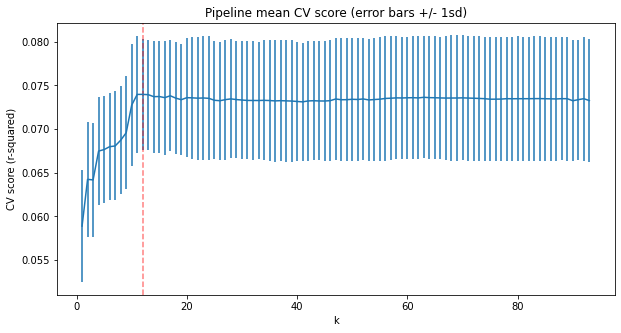

In [40]:
# Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [41]:
# Print the list of the features in order of importance
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

NumClaimsYr1            377.912700
AmtClaimsYr1            226.127304
AgeYr1                  157.870145
BreedAvgClaimAmt        107.082227
BreedAvgPremium          54.338071
AgeYr1AvgClaimAmt        43.898197
BreedAvgDeductible       41.295419
BreedAvgNumClaims        33.625290
AgeYr1AvgTotalClaims      7.297424
AvgClaimsYr1            -24.354952
BreedAvgTotalClaims     -42.020214
Species                 -68.129531
dtype: float64

The most important feature in our data appears to be the number of claims in year 1 followed closely by the amount of claims in year 1. This matches up with what we observed during EDA, where these two features were most closely correlated with our target. Beyond these two, pet age also scores high in terms of importance followed by a number of features that are rollups of breed and age related statistics. Surprisingly, the importance of species appears to be lower than expected.

Next, let's create a random forest model and see how it performs in comparison to our linear regression model.

### 7.3 Random Forest Regressor
We'll start with a basic random forest model as a baseline and then move on to do some hyperparameter tuning.

In [42]:
# Define a Random Forest Pipeline
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)

In [43]:
# Estimate the pipeline's performance.
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [44]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.05305499, -0.04917389, -0.05077174, -0.02282353,  0.00867651])

In [45]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.03342952852383709, 0.023745320817563757)

It looks like our baseline random forest model has actually performed worse than our linear regression model. That's not too surprising cconsidering we've done nothing to tune the available parameters. As a next step, let's incorporate a random grid search across a range of hyperparameters to see if we can improve our results.

We'll start by building a grid for our random search. Then we'll complete the random search across this grid using cross validation to see if we can arrive at a better set of hyperparameters. Finally, we'll compare the best parameters with our random forest baseline to see what kind of improvement we get.

### 7.4 Random Forest Hyperparameter Tuning

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Print the grid
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# Create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 5 fold cross validation, 
# search across 5 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [48]:
# View best performing parameter combination
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [57]:
# Establish base model for comparison
baseline_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_test)
print("r2_score (baseline): {:.2f}".format(r2_score(y_test, baseline_predictions)))
print("mean absolute error (baseline): {:.2f} \n".format(mean_absolute_error(y_test, baseline_predictions)))

# Compare with best model from random search
best_random_model = rf_random.best_estimator_
best_random_model.fit(X_train, y_train)
best_random_predictions = best_random_model.predict(X_test)
print("r2_score (best random): {:.2f}".format(r2_score(y_test, best_random_predictions)))
print("mean absolute error (best random): {:.2f} \n".format(mean_absolute_error(y_test, best_random_predictions)))

r2_score (baseline): -0.07
mean absolute error (baseline): 1018.40 

r2_score (best random): 0.06
mean absolute error (best random): 944.49 



So even using the best random forest model, our performance is still looking slightly worse than with our linear model when looking at only the best k features. 

# TODO - Where to go from here??

### 7.5 


## 8 Save Model

In [ ]:
# # Store some basic information about the model
# best_model = rf_grid_cv.best_estimator_
# best_model.version = '1.0'
# best_model.pandas_version = pd.__version__
# best_model.numpy_version = np.__version__
# best_model.sklearn_version = sklearn_version
# best_model.X_columns = [col for col in X_train.columns]
# best_model.build_datetime = datetime.datetime.now()

In [ ]:
# # save the model

# modelpath = '../models'
# save_file(best_model, 'ski_resort_pricing_model.pkl', modelpath)

## 8 Summary

TBD